In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam
import flax
import jax_dataclasses as jdc
import tqdm

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
DATAFILE = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [3]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [4]:
LASER_DATA_LIST = []
with open(DATAFILE, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        LASER_DATA_LIST.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [5]:
def show_points(laser_data_list, indeces):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")

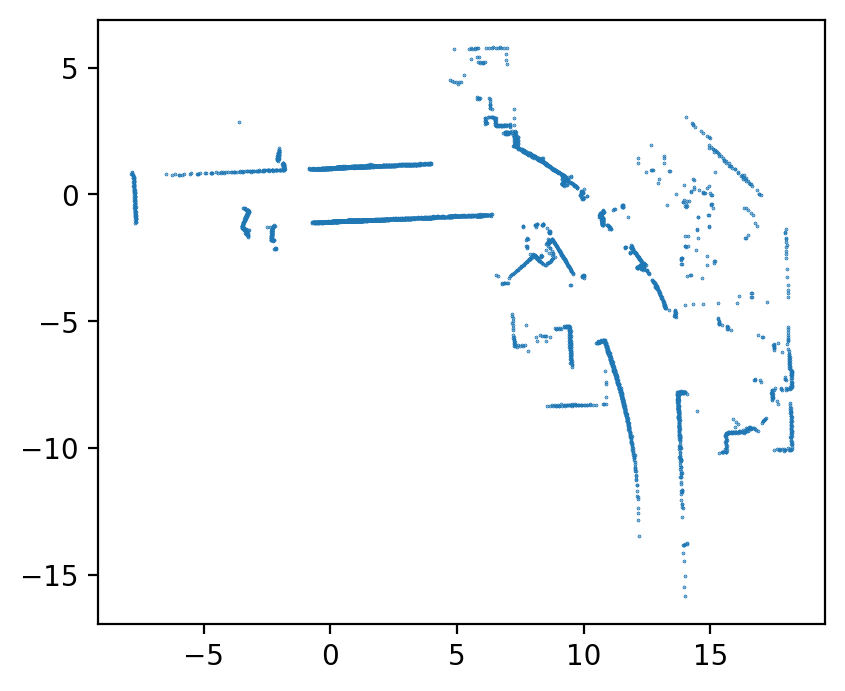

In [6]:
laser_data_list = LASER_DATA_LIST
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

# Rendering

In [7]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [8]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [9]:
MODEL = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
VARIABLES = MODEL.init(jax.random.PRNGKey(1), batch)
output = MODEL.apply(VARIABLES, batch)

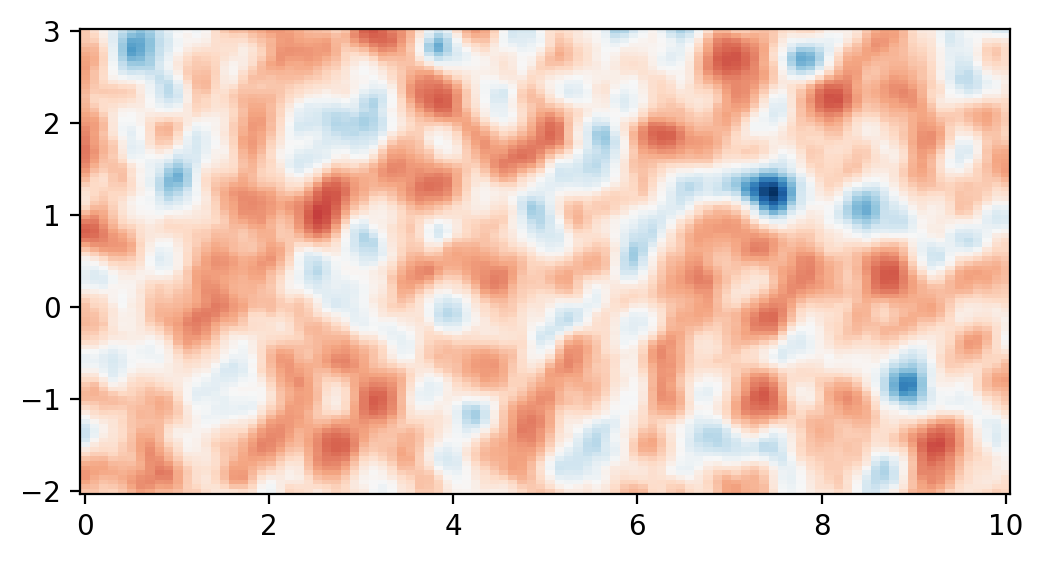

In [10]:
plt.figure(dpi=200)
k = 1
k = 1
bounds = (0 * k, 10 * k, -2 * k, 3 * k)
grid_shape=(200, 200)
plot_model_heatmap(MODEL, VARIABLES, bounds, grid_shape)

# Space hashing

In [11]:
@jax.jit
def hashfunction(x, T):
    pi1 = 1
    pi2 = 19349663
    pi3 = 83492791
    result = jnp.bitwise_xor(x[:, 0] * pi1, x[:, 1] * pi2)
    return result % T

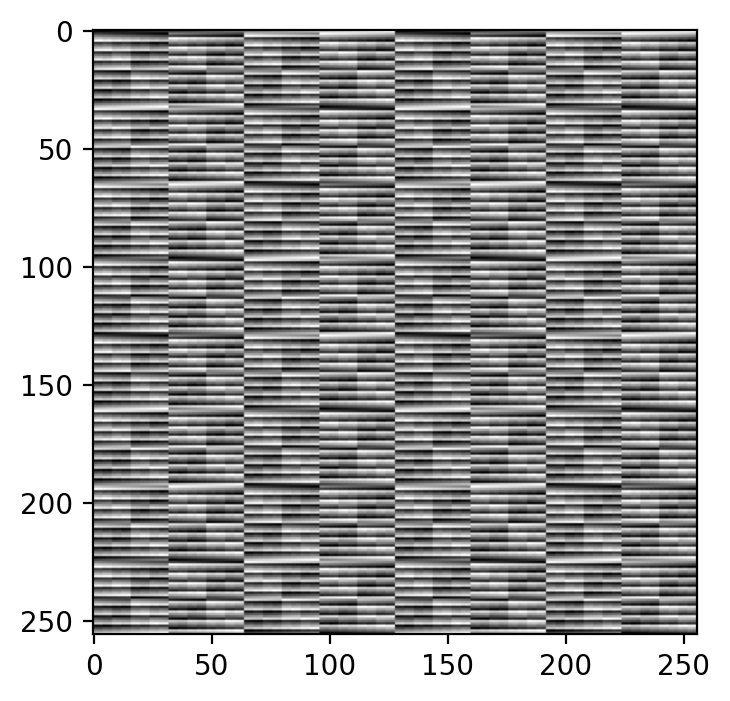

In [12]:
x, y = jnp.meshgrid(jnp.arange(256), jnp.arange(256))
points = jnp.stack([x, y], axis=2)
values = hashfunction(points.reshape(-1, 2), 128).reshape(256, 256)
plt.figure(dpi=200)
plt.imshow(values, cmap="gray")

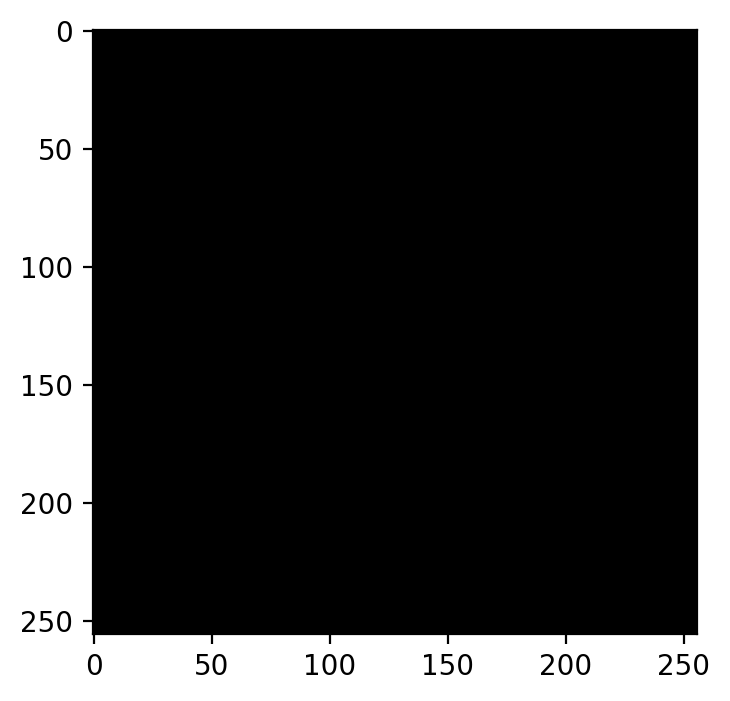

In [13]:
random_reindex = np.random.choice(np.arange(1024), 1024, replace=False)
random_reindex = jnp.array(random_reindex)
plt.figure(dpi=200)
plt.imshow(random_reindex[values] == 30, cmap="gray")

In [806]:
def kernel_init(*args):
#     print(jax.nn.initializers.lecun_normal()(*args))
#     print(1 / np.sqrt(2) * jax.nn.initializers.lecun_normal()(*args))
    return np.sqrt(2) * jax.nn.initializers.lecun_normal()(*args)

class MLPModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, use_bias=True, kernel_init=kernel_init)(x)
        x = nn.relu(x)
        x = nn.Dense(256, use_bias=True, kernel_init=kernel_init)(x)
        x = nn.relu(x)
        x = nn.Dense(256, use_bias=True, kernel_init=kernel_init)(x)
        x = nn.relu(x)
#         x1 = x
#         x1 = nn.Dense(256)(x1)
#         x1 = nn.relu(x1)
#         x = jnp.concatenate([x, x1], axis=-1)
# #         x = x1
#         x = nn.Dense(256)(x)
#         x = nn.relu(x)
        x = nn.Dense(1, kernel_init=kernel_init)(x)
        return x[:, 0]

In [807]:
def step_function(x):
    return x * x * (3 - 2 * x) * np.sqrt(4 / 3)

@jax.jit
def bilinear_interpolation(deltas, values0, values1, values2, values3):
    f1 = values0 * step_function(1 - deltas[:, 0])[:, None] + values1 * step_function(deltas)[:, 0][:, None]
    f2 = values2 * step_function(1 - deltas[:, 0])[:, None] + values3 * step_function(deltas)[:, 0][:, None]
    return f1 * step_function(1 - deltas[:, 1])[:, None] + f2 * step_function(deltas)[:, 1][:, None]

@functools.partial(jax.jit, static_argnums=[4])
def calculate_layer_embeddings(hashtable, points, resolution, origin, T, rotation):
    points = ((points - origin) / resolution)
    x = jnp.cos(rotation) * points[:, 0] - jnp.sin(rotation) * points[:, 1]
    y = jnp.sin(rotation) * points[:, 0] + jnp.cos(rotation) * points[:, 1]
    points = jnp.stack([x, y], axis=1)
    cells = jnp.array(points // 1, jnp.int32)
    deltas = points % 1
    values0 = hashtable[hashfunction(cells, T)]
    values1 = hashtable[hashfunction(cells + jnp.array([1, 0]), T)]
    values2 = hashtable[hashfunction(cells + jnp.array([0, 1]), T)]
    values3 = hashtable[hashfunction(cells + jnp.array([1, 1]), T)]
    return bilinear_interpolation(deltas, values0, values1, values2, values3)

# Train hashtabel

In [808]:
@jdc.pytree_dataclass
class MapModel(object):
    hashtable: jnp.array
    variables: flax.core.frozen_dict.FrozenDict
    resolutions: jnp.array
    origins: jnp.array
    rotations: jnp.array
        
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    F: int
    L: int
    T: int
    max_log_resolution: float
    min_log_resolution: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [829]:
# @functools.partial(jax.jit, static_argnums=[2, 3])
def calculate_densities(points: jnp.array, map_model: MapModel, model: MLPModel, L):
    embeddings = []
#     print(jnp.std(map_model.hashtable))
    for i in range(L):
        embedding = calculate_layer_embeddings(map_model.hashtable[i], 
                                               points, 
                                               map_model.resolutions[i], 
                                               map_model.origins[i], 
                                               map_model.hashtable.shape[1], 
                                               map_model.rotations[i])
        embeddings.append(embedding)
#     embedding = jnp.stack(embeddings, axis=0)
#     embedding = jnp.sum(embedding, axis=0)
    embedding = jnp.concatenate(embeddings, axis=1)
#     print(jnp.std(embedding))
#     print(jnp.mean(embedding))
#     print("std model output", jnp.std(model.apply(map_model.variables, embedding)))
#     print("mean model output", jnp.mean(model.apply(map_model.variables, embedding)))
    return jax.nn.softplus(model.apply(map_model.variables, embedding))
#     return model.apply(map_model.variables, embedding)

In [830]:
# calculate_densities(grid, map_model, model);

In [831]:
# %timeit calculate_densities(grid, map_model, model).block_until_ready()

In [832]:
# grid_shape=(20, 10)
# grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
#                               jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
# grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
# # jax.make_jaxpr(calculate_densities, static_argnums=2)(grid, map_model, model)
# print(jax.make_jaxpr(calculate_densities, static_argnums=2)(grid, map_model, model))

In [835]:
def plot_model_heatmap(map_model, bounds):

    grid_shape=(200, 200)
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]), 
                              jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = calculate_densities(grid, map_model, model, map_model.hashtable.shape[0])
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(*grid_shape)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
#     print(jnp.std(obstacle_probabilites))
#     print(jnp.mean(obstacle_probabilites))
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=None, vmax=None)
    plt.gca().set_aspect('equal')

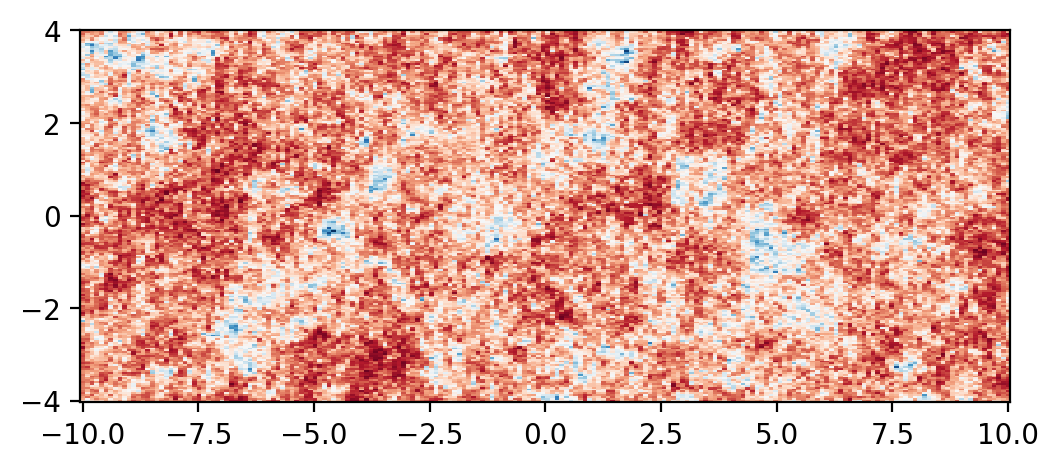

In [836]:
plt.figure(dpi=200)
F=32
L=4
T=2048
hashtable = jax.random.normal(jax.random.PRNGKey(8), (L, T, F))
resolutions = 2 ** jnp.linspace(-4, 1, L)
origins = jnp.zeros(2) + jax.random.normal(jax.random.PRNGKey(2), (L, 2))
rotations = jax.random.uniform(jax.random.PRNGKey(10), (L,)) * 2 * np.pi
k = 1
# bounds = (0 * k, 10 * k, -2 * k, 3 * k)
bounds = (-10, 10, -4, 4)
grid_shape=(400, 400)

model = MLPModel()
batch = jnp.ones([10, F * L])
variables = model.init(jax.random.PRNGKey(4), batch)
output = model.apply(variables, batch)
map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=resolutions,
                     origins=origins, rotations=rotations)
plot_model_heatmap(map_model, bounds)

In [837]:
@jdc.pytree_dataclass
class ScanData(object):
    depths: jnp.array
    angles: jnp.array

        
@jdc.pytree_dataclass
class LearningData(object):
    uniform: jnp.array
        
        
@jdc.pytree_dataclass
class Position(object):
    x: jnp.array
    y: jnp.array
    angle: jnp.array


        
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(learning_data, parameters):
#     return sample_depth_bins_exp(learning_data, parameters)
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * learning_data.uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins_exp(learning_data, parameters):
    weights = jnp.exp(jnp.linspace(0, 1, parameters.bins_count) * 0.017 * parameters.bins_count)
    deltas = weights / jnp.sum(weights) * (parameters.maximal_depth - parameters.minimal_depth)
    depths = jnp.cumsum(deltas) + parameters.minimal_depth
    sampled_depths = depths[None] - learning_data.uniform * deltas[None]
    return jnp.concatenate([jnp.full([sampled_depths.shape[0], 1], parameters.minimal_depth), 
                            sampled_depths, 
                            jnp.full([sampled_depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, position):
    x = position[..., 0, None]
    y = position[..., 1, None]
    angle = position[..., 2, None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, scan_data: ScanData):
    x = depths * jnp.cos(scan_data.angles[..., None])
    y = depths * jnp.sin(scan_data.angles[..., None])
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=[4, 5])
def loss_function(map_model: MapModel, position: jnp.array, scan_data: ScanData, 
                  learning_data:LearningData, config: ModelConfig, model: MLPModel):
    depth_bins = sample_depth_bins(learning_data, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = config.density_scale * calculate_densities(points, map_model, model, config.L).reshape(
        depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((scan_data.depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-1) +
                   config.variance_weight * predicted_variance)

@functools.partial(jax.jit, static_argnums=[4, 5])
def predict_dephs(map_model: MapModel, position: jnp.array, scan_data: ScanData, 
                  learning_data:LearningData, config: ModelConfig, model: MLPModel):
    depth_bins = sample_depth_bins(learning_data, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = config.density_scale * calculate_densities(points, map_model, model, config.L).reshape(
        depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    return jnp.sum(weights * extended_depths, axis=-1)


In [838]:
def init_map_model(model, config):
    hashtable = jax.random.normal(jax.random.PRNGKey(1), (config.L, config.T, config.F))
    resolutions = 2 ** jnp.linspace(config.min_log_resolution, config.max_log_resolution, config.L)
    origins = jnp.zeros(2) + jax.random.normal(jax.random.PRNGKey(2), (config.L, 2))
    rotations = jax.random.uniform(jax.random.PRNGKey(10), (L,)) * 2 * np.pi
    batch = jnp.ones([10, config.F * config.L])
#     batch = jnp.ones([10, config.F])
    variables = model.init(jax.random.PRNGKey(1), batch)
    output = model.apply(variables, batch)
    return MapModel(hashtable=hashtable, variables=variables, resolutions=resolutions,
                         origins=origins, rotations=rotations)

In [839]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.5,
    variance_weight=0.5,
    F=32,
    L=8,
    T=4096,
    min_log_resolution=-1.,
    max_log_resolution=3.
)
n = 256
position = jnp.ones(3)
scan_data = ScanData(angles=jnp.ones(n), depths=jnp.ones(n))
learning_data = LearningData(uniform=jnp.ones([n, config.bins_count]))
map_model =  init_map_model(model, config)
loss = loss_function(map_model, position, scan_data, learning_data, config, model)



In [840]:
grad_function = jax.jit(jax.grad(loss_function), static_argnums=[4, 5])
grad = grad_function(map_model, position, scan_data, learning_data, config, model)

In [841]:
# print(jax.make_jaxpr(loss_function, static_argnums=[4, 5])(map_model,
#     position, scan_data, learning_data, config, model))

# %timeit loss_function(map_model, position, scan_data, learning_data, config, model).block_until_ready()

In [842]:
# print(jax.make_jaxpr(grad_function, static_argnums=[4, 5])(map_model,
#     position, scan_data, learning_data, config, model))

# %timeit -r 4 -n 100  grad_function(map_model, position, scan_data, learning_data, config, model).hashtable.block_until_ready()

# Model training

In [1017]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.05,
    variance_weight=0.1,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=1.
)

iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
scan_data = ScanData(angles=jnp.array(laser_data.angles[mask]), depths=jnp.array(laser_data.ranges[mask]))
print(jnp.mean(scan_data.depths))
learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(5), 
                                                        (len(scan_data.depths), config.bins_count)))

x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
position = jnp.array([x, y, angle])
map_model =  init_map_model(model, config)
variable_optimizer = Adam(2e-2, beta1=0.9, beta2=0.99, eps=1e-15, weight_decay=1e-6)
variable_state = variable_optimizer.init_state(map_model.variables)
hashtable_optimizer = Adam(2e-2, beta1=0.9, beta2=0.99, eps=1e-15)
hashtable_state = hashtable_optimizer.init_state(map_model.hashtable)

learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
loss_history = []
init_hashtable = map_model.hashtable
hashtable = map_model.hashtable
variables = map_model.variables
for i in tqdm.tqdm(range(iterations)):
    learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(i), 
        (len(scan_data.depths), config.bins_count)))
    grad = grad_function(map_model, position, scan_data, learning_data, config, model)
    loss = loss_function(map_model, position, scan_data, learning_data, config, model)
    loss_history.append(loss)
    variables, variable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                   map_model.variables,
                                                           variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                    map_model.hashtable, 
                                                          hashtable_state, grad.hashtable)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                         origins=map_model.origins, rotations=map_model.rotations)


2.5408044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.24it/s]


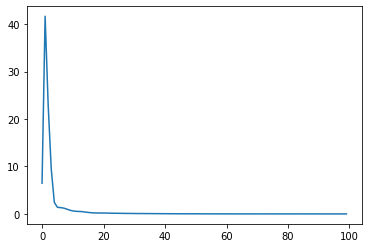

In [1018]:
plt.plot(loss_history)

In [1019]:
jnp.mean(map_model.hashtable)

DeviceArray(0.00532494, dtype=float32)

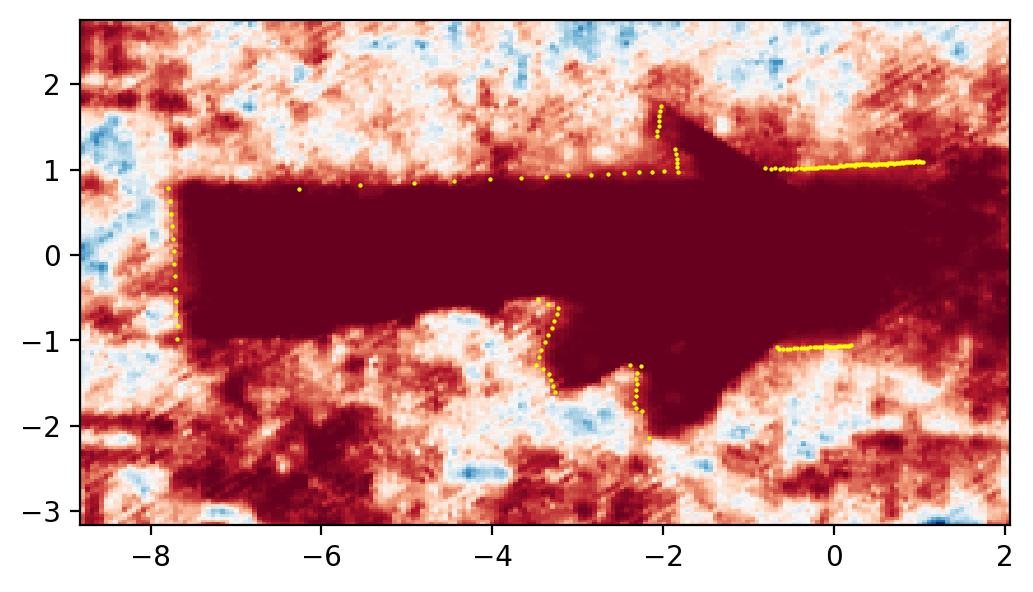

In [1020]:
plt.figure(dpi=200)
# plot_model_heatmap(map_model, (-10, 10, -4, 4))
l_threshold = 0
new_hashtable = jnp.concatenate([jnp.zeros((l_threshold, config.T, config.F)), 
                                 map_model.hashtable[l_threshold:]], axis=0)
# new_hashtable = jnp.concatenate([map_model.hashtable[:l_threshold],
#                                  jnp.zeros((config.L - l_threshold, config.T, config.F))], axis=0)
new_map_model = MapModel(hashtable=new_hashtable, variables=map_model.variables, resolutions=map_model.resolutions,
                        origins=map_model.origins, rotations=map_model.rotations)

all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(new_map_model, bounds)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

In [1021]:
def get_scan_data(laser_data):
    mask = laser_data.ranges < 10
    return ScanData(angles=jnp.array(laser_data.angles[mask]), depths=jnp.array(laser_data.ranges[mask]))

0.013063362


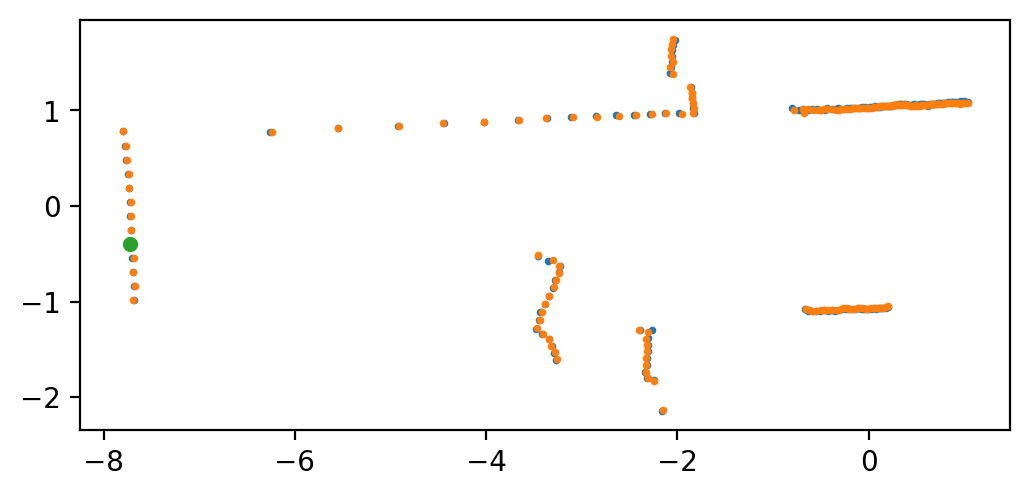

In [1022]:
plt.figure(dpi=200)
index = learning_index
laser_data = laser_data_list[index]
scan_data = get_scan_data(laser_data)
learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
position = jnp.array([x, y, angle])

predicted_depths = predict_dephs(new_map_model, position, scan_data, learning_data, config, model)
print(jnp.sqrt(jnp.mean((predicted_depths - scan_data.depths) ** 2)))
new_points = np.stack([np.cos(scan_data.angles) * predicted_depths, 
                       np.sin(scan_data.angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
point_index = 114
plt.scatter(new_points[point_index, 0], new_points[point_index, 1], s=20)

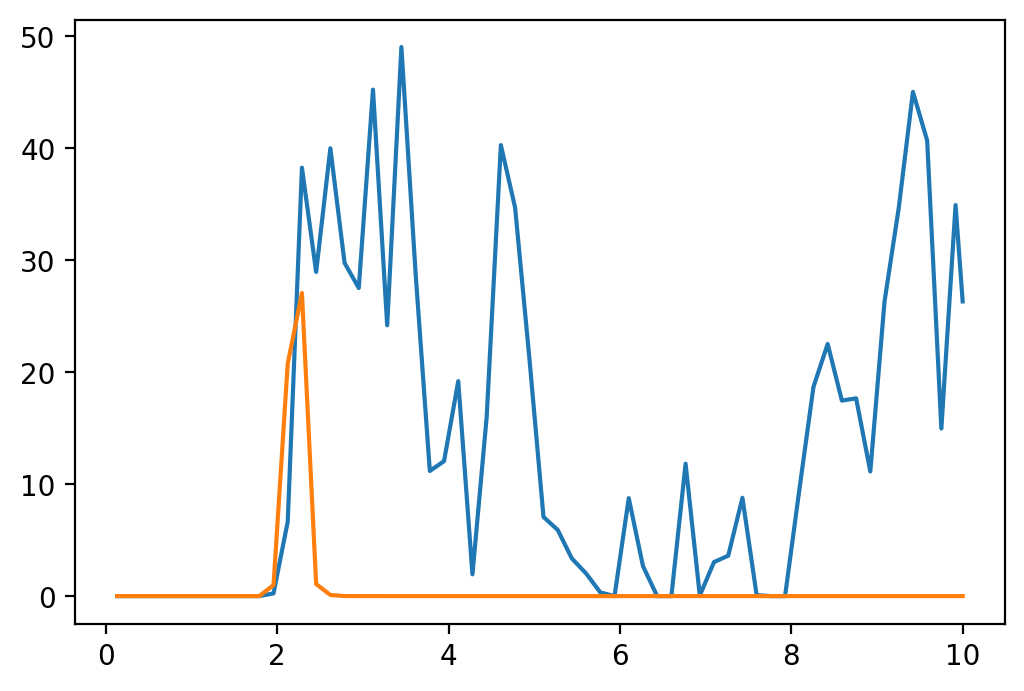

In [868]:
plt.figure(dpi=200)
scan_index = 113
learning_data = LearningData(uniform=jnp.ones((1, config.bins_count)) * 0.5)
small_scan_data = ScanData(
    depths=scan_data.depths[scan_index:scan_index + 1],
    angles=scan_data.angles[scan_index:scan_index + 1]
)
depth_bins = sample_depth_bins(learning_data, config)
# depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depths = depth_bins[..., 1:]
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, small_scan_data)
points = transform_points(points, position).reshape(-1, 2)
densities = config.density_scale * calculate_densities(points, map_model, model, config.L).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
plt.plot(depths[0], densities[0])
plt.plot(extended_depths[0], weights[0] * 50)
# weights = jax.vmap(calculate_weights)(densities, depth_deltas)
# extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)

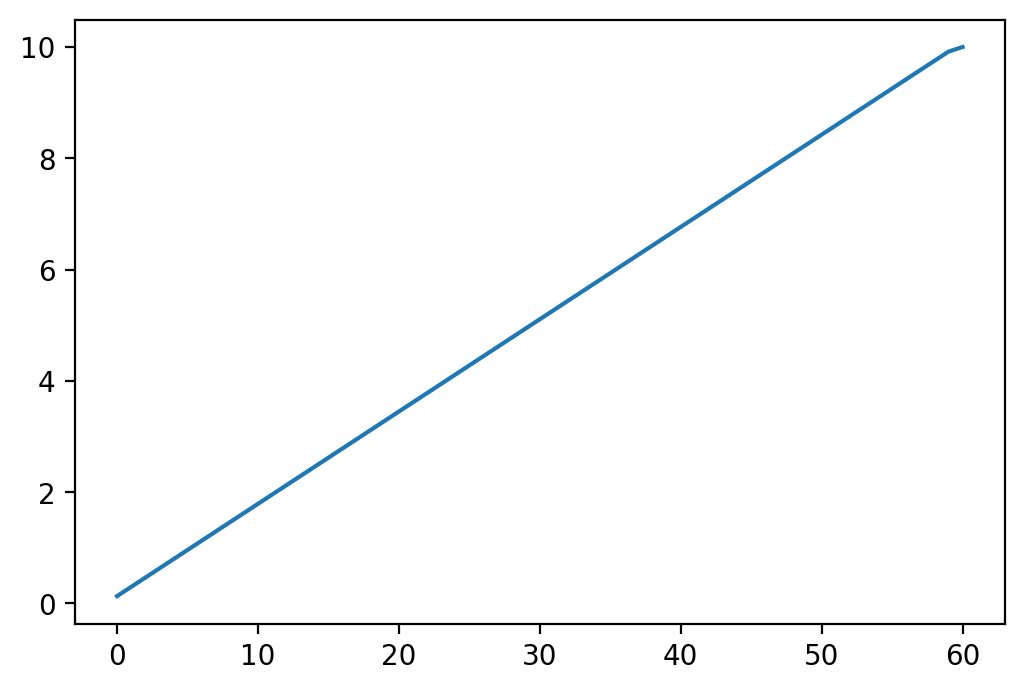

In [370]:
plt.figure(dpi=200)
plt.plot(depths[0])

# Optimize on several images

In [371]:
@dataclass
class DataPointBatch(object):
    depths: jnp.array
    angles: jnp.array
    x: jnp.array
    y: jnp.array
    angle: jnp.array
        
    @property
    def scan_data(self):
        return ScanData(depths=self.depths, angles=self.angles)

    @property
    def position(self):
        return jnp.stack([self.x, self.y, self.angle], axis=1)

In [516]:
def get_random_data_point_batch(laser_data_list, laser_data_indeces, scan_count, points_per_scan):
    laser_data_indeces = np.random.choice(laser_data_indeces, scan_count, replace=False)
    scan_point_indeces = np.random.choice(np.arange(180), (scan_count, points_per_scan))
    depths = []
    angles = []
    x = []
    y = []
    angle = []
    for i in range(scan_count):
        laser_data = laser_data_list[laser_data_indeces[i]]
        scan_point_index = scan_point_indeces[i]
        mask = laser_data.ranges[scan_point_index] < 10
        indeces = np.arange(mask.shape[0])[mask]
        indeces = np.random.choice(indeces, points_per_scan)
        depths.extend(list(laser_data.ranges[scan_point_index][indeces]))
        angles.extend(list(laser_data.angles[scan_point_index][indeces]))
        x.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.x)))
        y.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.y)))
        angle.extend(list(np.full(indeces.shape[0], laser_data.odometry_position.rotation)))
    return DataPointBatch(
        depths = jnp.array(depths),
        angles = jnp.array(angles),
        x = jnp.array(x),
        y = jnp.array(y),
        angle = jnp.array(angle)
    )

In [517]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.1,
    variance_weight=0.1,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=0.
)

max_laser_data_index = 910
# max_laser_data_index = 30
laser_data_indices = np.arange(max_laser_data_index)
iterations = 1200 * 5
map_model =  init_map_model(model, config)
variable_optimizer = Adam(2e-2, beta1=0.9, beta2=0.99, eps=1e-15, weight_decay=1e-6)
variable_state = variable_optimizer.init_state(map_model.variables)
hashtable_optimizer = Adam(1e-2, beta1=0.9, beta2=0.99, eps=1e-15)
hashtable_state = hashtable_optimizer.init_state(map_model.hashtable)

learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
loss_history = []
for i in tqdm.tqdm(range(iterations)):
    batch = get_random_data_point_batch(laser_data_list, laser_data_indices, 5, 100)
    scan_data = batch.scan_data
    position = batch.position
    learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(i), 
        (len(scan_data.depths), config.bins_count)))
    grad = grad_function(map_model, position, scan_data, learning_data, config, model)
    loss = loss_function(map_model, position, scan_data, learning_data, config, model)
    loss_history.append(loss)
    variables, variable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                   map_model.variables,
                                                           variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(hashtable_optimizer.hyper_params, 
                                                                    map_model.hashtable, 
                                                          hashtable_state, grad.hashtable)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                         origins=map_model.origins, rotations=map_model.rotations)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [04:58<00:00, 20.13it/s]


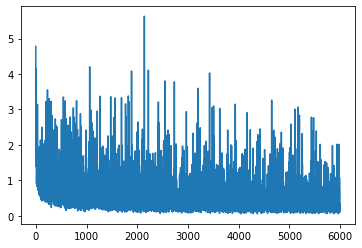

In [518]:
plt.plot(loss_history)

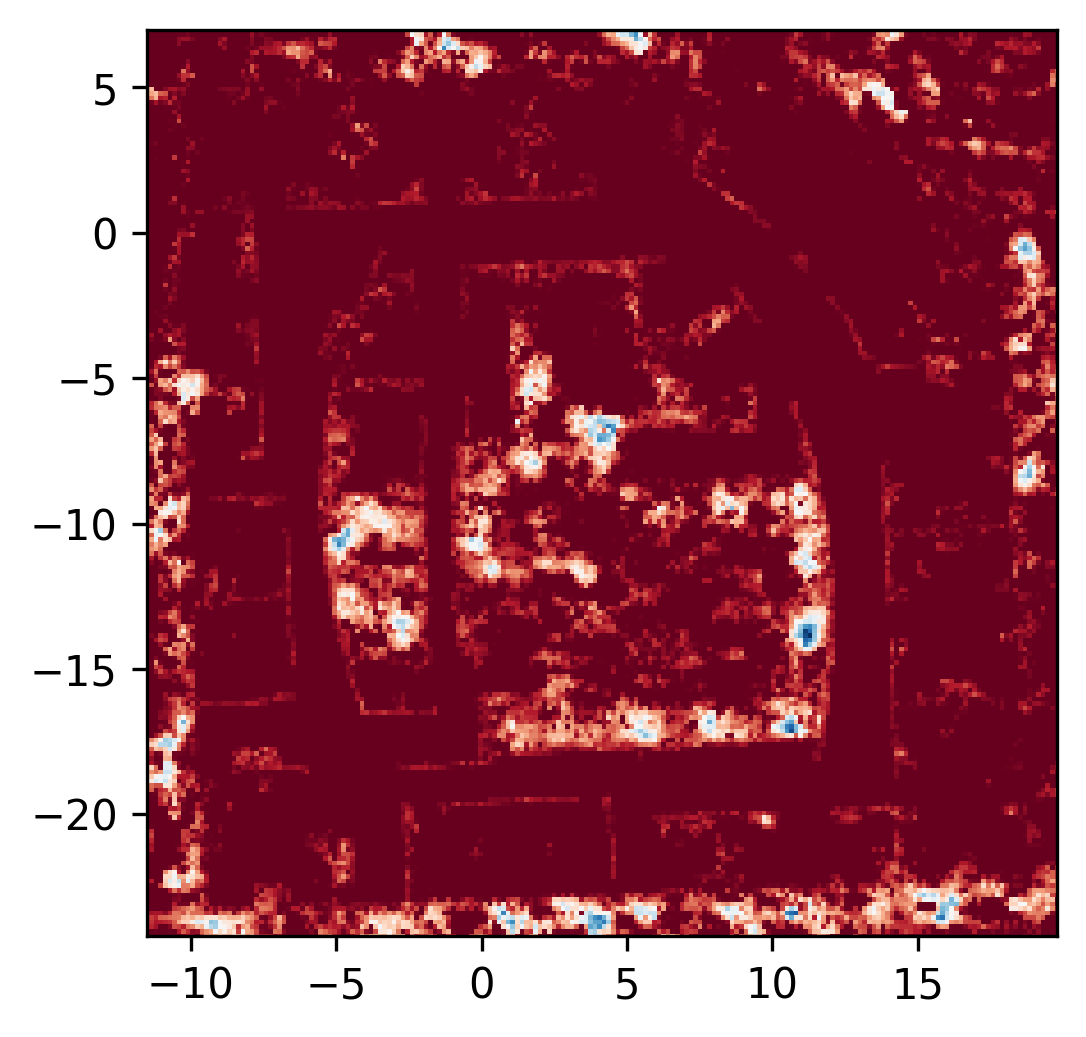

In [527]:
plt.figure(dpi=300)
# plot_model_heatmap(map_model, (-10, 10, -4, 4))
l_threshold = 0
new_hashtable = jnp.concatenate([jnp.zeros((l_threshold, config.T, config.F)), 
                                 map_model.hashtable[l_threshold:]], axis=0)
# new_hashtable = jnp.concatenate([map_model.hashtable[:l_threshold],
#                                  jnp.zeros((config.L - l_threshold, config.T, config.F))], axis=0)
new_map_model = MapModel(hashtable=new_hashtable, variables=map_model.variables, resolutions=map_model.resolutions,
                        origins=map_model.origins, rotations=map_model.rotations)

all_points = []

for i in laser_data_indices:
    all_points.append(laser_data_list[i].as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
# bounds = (5, 10, -4, 0)
plot_model_heatmap(new_map_model, bounds)
# plt.scatter(points[:, 0], points[:, 1], s=0.1, c="yellow")
plt.gca().set_aspect('equal')
plt.xlim(bounds[0], bounds[1])
plt.ylim(bounds[2], bounds[3]);

0.22623768


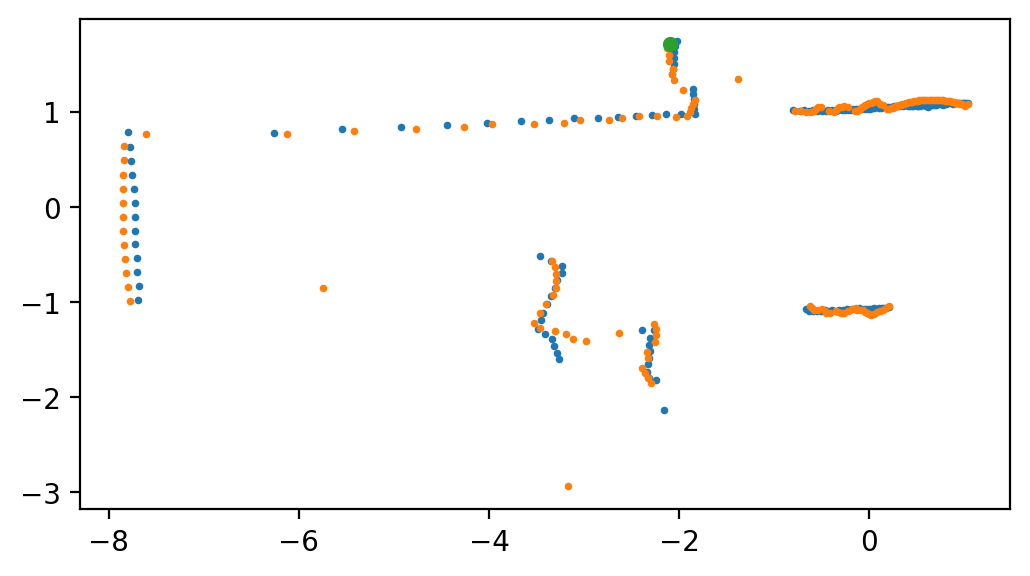

In [521]:
plt.figure(dpi=200)
index = 6
laser_data = laser_data_list[index]
scan_data = get_scan_data(laser_data)
learning_data = LearningData(uniform=jnp.ones((scan_data.angles.shape[0], config.bins_count)) * 0.5)
# learning_data = LearningData(uniform=jax.random.uniform(jax.random.PRNGKey(0), 
#         (len(scan_data.depths), config.bins_count)))
x = laser_data.odometry_position.x
y = laser_data.odometry_position.y
angle = laser_data.odometry_position.rotation
position = jnp.array([x, y, angle])

predicted_depths = predict_dephs(new_map_model, position, scan_data, learning_data, config, model)
print(jnp.sqrt(jnp.mean((predicted_depths - scan_data.depths) ** 2)))
new_points = np.stack([np.cos(scan_data.angles) * predicted_depths, 
                       np.sin(scan_data.angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
measurement_points = np.concatenate(all_points, axis=0)
plt.scatter(measurement_points[:, 0], measurement_points[:, 1], s=3)
plt.gca().set_aspect('equal')
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
point_index = 80
plt.scatter(new_points[point_index, 0], new_points[point_index, 1], s=20)

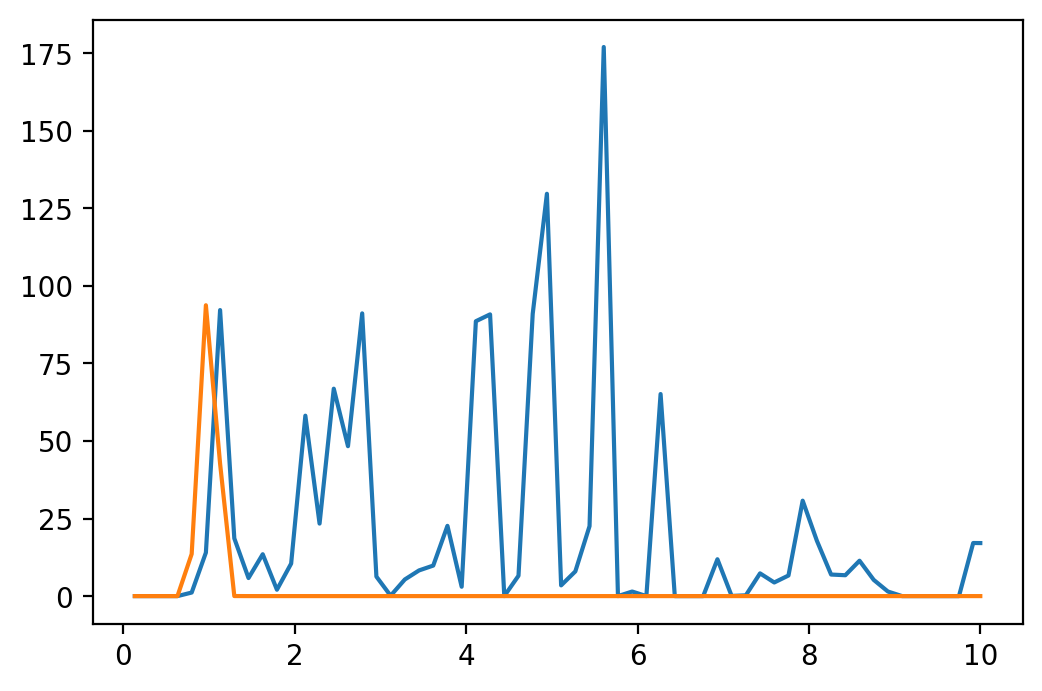

In [514]:
plt.figure(dpi=200)
scan_index = 30
extended_config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=3,
    F=32,
    L=4,
    T=2048,
    min_log_resolution=-4,
    max_log_resolution=1.
)
learning_data = LearningData(uniform=jnp.ones((1, extended_config.bins_count)) * 0.5)
small_scan_data = ScanData(
    depths=scan_data.depths[scan_index:scan_index + 1],
    angles=scan_data.angles[scan_index:scan_index + 1]
)
depth_bins = sample_depth_bins(learning_data, config)
# depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
depths = depth_bins[..., 1:]
depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
points = calculate_points(depths, small_scan_data)
points = transform_points(points, position).reshape(-1, 2)
densities = config.density_scale * calculate_densities(points, map_model, model, extended_config.L).reshape(depths.shape[:2])
weights = jax.vmap(calculate_weights)(densities, depth_deltas)
extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
plt.plot(depths[0], densities[0])
plt.plot(extended_depths[0], weights[0] * 150)
# weights = jax.vmap(calculate_weights)(densities, depth_deltas)
# extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)